In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pickle
import os
import admix_prs
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import admix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
np.random.seed(1)
trait = "bmi"
var_e = 0.75 # hsq = 0.25
# target at [5%, 95%] interval
TARGET_QUANTILE = 0.05
TARGET_QUANTILE_Z = scipy.stats.norm.ppf(1 - TARGET_QUANTILE)
PRS_PATH = f"/u/project/sgss/UKBB/PRS-RESEARCH/03-kangcheng-real-prs/out/PREDICTION/{trait}.tsv.gz"
INFO_PATH = "/u/project/sgss/UKBB/PRS-RESEARCH/02-yi-simulate-prs/subcontinenal/meta/covariates.txt"
PHENO_PATH = f"/u/project/pasaniuc/kangchen/tmp/prs-1219/REAL-PHENO/{trait}.raw.pheno"

In [13]:
df_prs = pd.read_csv(PRS_PATH, sep="\t")
df_prs["indiv"] = df_prs["indiv"].apply(lambda x: x.split("_")[0])
df_prs = df_prs.set_index("indiv")
df_prs["MEAN"] -= df_prs["MEAN"].mean()
df_prs = df_prs.dropna()
df_prs.index = df_prs.index.astype(int)
df_prs["PHENO_STD"] = np.sqrt(df_prs["SD"] ** 2 + var_e)
df_prs["PHENO"] = df_prs["MEAN"] + df_prs["PHENO_STD"]
df_prs["PHENO_LOWER"] = df_prs["MEAN"] - df_prs["PHENO_STD"] * TARGET_QUANTILE_Z
df_prs["PHENO_UPPER"] = df_prs["MEAN"] + df_prs["PHENO_STD"] * TARGET_QUANTILE_Z
df_prs["PRS_LOWER"] = df_prs["QUANTILE_5"]
df_prs["PRS_UPPER"] = df_prs["QUANTILE_95"] 
df_prs

,MEAN,SD,QUANTILE_5,QUANTILE_10,QUANTILE_15,QUANTILE_20,QUANTILE_25,QUANTILE_30,QUANTILE_35,QUANTILE_40,...,QUANTILE_80,QUANTILE_85,QUANTILE_90,QUANTILE_95,PHENO_STD,PHENO,PHENO_LOWER,PHENO_UPPER,PRS_LOWER,PRS_UPPER
indiv,,,,,,,,,,,,,,,,,,,,,
4305423,0.426943,0.48757,-0.16516,0.04499,0.17383,0.29983,0.37615,0.44806,0.50610,0.56655,...,1.09551,1.17859,1.32097,1.43672,0.993843,1.420787,-1.207783,2.061670,-0.16516,1.43672
4360126,0.743493,0.50179,0.13346,0.35639,0.50398,0.58972,0.67841,0.74536,0.80782,0.85888,...,1.38882,1.49347,1.62518,1.86918,1.000896,1.744390,-0.902834,2.389821,0.13346,1.86918
4187429,-0.256827,0.48639,-0.84952,-0.63838,-0.49048,-0.37840,-0.30370,-0.24470,-0.18461,-0.13517,...,0.41725,0.49668,0.62957,0.75810,0.993265,0.736438,-1.890602,1.376949,-0.84952,0.75810
1004389,-0.463227,0.48206,-0.97483,-0.82356,-0.72624,-0.60168,-0.52469,-0.45981,-0.41332,-0.35368,...,0.15594,0.27193,0.43515,0.61574,0.991152,0.527925,-2.093526,1.167073,-0.97483,0.61574
1387182,0.103233,0.49115,-0.49718,-0.28930,-0.18445,-0.07302,0.00709,0.09231,0.16953,0.22288,...,0.80267,0.86993,0.98681,1.11161,0.995605,1.098838,-1.534390,1.740857,-0.49718,1.11161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498323,-0.089127,0.48179,-0.63911,-0.44585,-0.35012,-0.25852,-0.18104,-0.10259,-0.03572,0.05684,...,0.53437,0.64598,0.78231,0.94248,0.991020,0.901894,-1.719210,1.540957,-0.63911,0.94248
4386997,0.472563,0.48804,-0.03869,0.09910,0.22120,0.30718,0.38144,0.45492,0.53686,0.59652,...,1.13859,1.20815,1.28696,1.49401,0.994074,1.466637,-1.162543,2.107670,-0.03869,1.49401
4647541,0.228153,0.48941,-0.35322,-0.14627,-0.03681,0.07501,0.16651,0.24425,0.30513,0.37026,...,0.86506,0.98754,1.08589,1.26673,0.994747,1.222901,-1.408060,1.864367,-0.35322,1.26673


In [14]:
df_trait_pheno = pd.read_csv(PHENO_PATH, sep="\t")
df_trait_pheno.index = df_trait_pheno["FID"]
df_trait_pheno = df_trait_pheno.drop(columns=["FID"])
df_trait_pheno = df_trait_pheno.dropna()
df_trait_pheno = df_trait_pheno.rename(columns={"PHENO": "REAL"})
df_trait_pheno.index = df_trait_pheno.index.astype(int)
df_trait_pheno["REAL"] = admix.data.quantile_normalize(df_trait_pheno["REAL"])

df_anc = pd.read_csv(INFO_PATH, sep="\t")
df_anc = df_anc.set_index("eid")
df_prs.index = df_prs.index.astype(int)

df_info = pd.merge(
    df_prs[["MEAN", "SD", "PHENO", "PHENO_STD", "PHENO_LOWER", "PHENO_UPPER", "PRS_LOWER", "PRS_UPPER"]], 
    df_anc[["sex", "age", "PC1", "PC2", "group"]], 
    left_index=True, 
    right_index=True
)

df_info = pd.merge(
    df_info, 
    df_trait_pheno["REAL"], 
    left_index=True, 
    right_index=True
)

df_admix = df_info.loc[df_info["group"]=="Caribbean"]
df_admix["PC1_Q"] = admix_prs.make_levels(df_admix, stratify_col="PC1", n_level=5)
df_admix["PC2_Q"] = admix_prs.make_levels(df_admix, stratify_col="PC2", n_level=5)
df_admix["AGE_Q"] = admix_prs.make_levels(df_admix, stratify_col="age", n_level=5)
df_admix

<ipython-input-14-2936050612e0>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_admix["PC1_Q"] = admix_prs.make_levels(df_admix, stratify_col="PC1", n_level=5)
<ipython-input-14-2936050612e0>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_admix["PC2_Q"] = admix_prs.make_levels(df_admix, stratify_col="PC2", n_level=5)
<ipython-input-14-2936050612e0>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,MEAN,SD,PHENO,PHENO_STD,PHENO_LOWER,PHENO_UPPER,PRS_LOWER,PRS_UPPER,sex,age,PC1,PC2,group,REAL,PC1_Q,PC2_Q,AGE_Q
2516559,0.196533,0.61856,1.260778,1.064245,-1.553993,1.947060,-0.47462,1.50544,0,46,326.792,62.4450,Caribbean,0.838377,"(310.627, 336.648]","(27.348, 63.393]","(45.0, 49.0]"
2900473,0.356283,0.64940,1.438744,1.082460,-1.424205,2.136772,-0.44645,1.71402,0,46,369.861,68.7891,Caribbean,-0.829271,"(364.342, 374.904]","(66.751, 69.351]","(45.0, 49.0]"
4736406,0.091543,0.61816,1.155555,1.064012,-1.658601,1.841688,-0.75898,1.30104,1,50,349.910,65.9163,Caribbean,0.728813,"(336.648, 352.366]","(63.393, 66.751]","(49.0, 54.0]"
5482221,0.095013,0.62560,1.163365,1.068352,-1.662269,1.852296,-0.69918,1.33493,0,68,346.732,64.5957,Caribbean,-0.743123,"(336.648, 352.366]","(63.393, 66.751]","(61.0, 70.0]"
2001699,-0.337717,0.65718,0.749429,1.087146,-2.125912,1.450479,-1.15343,0.96521,1,56,334.719,67.3946,Caribbean,-0.131957,"(310.627, 336.648]","(66.751, 69.351]","(54.0, 61.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3989335,0.307093,0.63868,1.383157,1.076063,-1.462873,2.077060,-0.45633,1.62927,0,53,332.310,63.1114,Caribbean,0.219932,"(310.627, 336.648]","(27.348, 63.393]","(49.0, 54.0]"
3371009,-0.515317,0.66570,0.577000,1.092317,-2.312018,1.281385,-1.44503,0.75637,0,40,317.165,62.1423,Caribbean,0.059704,"(310.627, 336.648]","(27.348, 63.393]","(39.999, 45.0]"
3404205,-0.307237,0.63823,0.768560,1.075796,-2.076764,1.462291,-1.08269,0.98968,1,57,312.449,63.7949,Caribbean,-1.006676,"(310.627, 336.648]","(63.393, 66.751]","(54.0, 61.0]"
1243144,0.125673,0.60765,1.183614,1.057941,-1.614484,1.865831,-0.62052,1.36493,1,41,385.070,72.0722,Caribbean,-1.251106,"(374.904, 385.07]","(71.457, 78.484]","(39.999, 45.0]"


## Case 1: phenotype mean as a function of covariates

2022-01-27 17:32.38 [info     ] Regress pred_col=PRED against mean_adjust_cols=['PC1'] fitted with `calibrate_index` individuals
2022-01-27 17:32.38 [info     ] mean_model.summary():                             OLS Regression Results                            
Dep. Variable:                   REAL   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.159
Date:                Thu, 27 Jan 2022   Prob (F-statistic):              0.120
Time:                        17:32:38   Log-Likelihood:                -168.43
No. Observations:                 120   AIC:                             342.9
Df Residuals:                     117   BIC:                             351.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    st

/u/home/z/ziqixu09/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,r2,coverage,length
PC1_Q,,,
"(310.627, 336.648]",0.054292,0.919087,3.516780
"(336.648, 352.366]",0.030509,0.927235,3.534279
"(352.366, 364.342]",0.064900,0.935685,3.547832
"(364.342, 374.904]",0.044133,0.910603,3.558684
"(374.904, 385.07]",0.025890,0.931535,3.566564


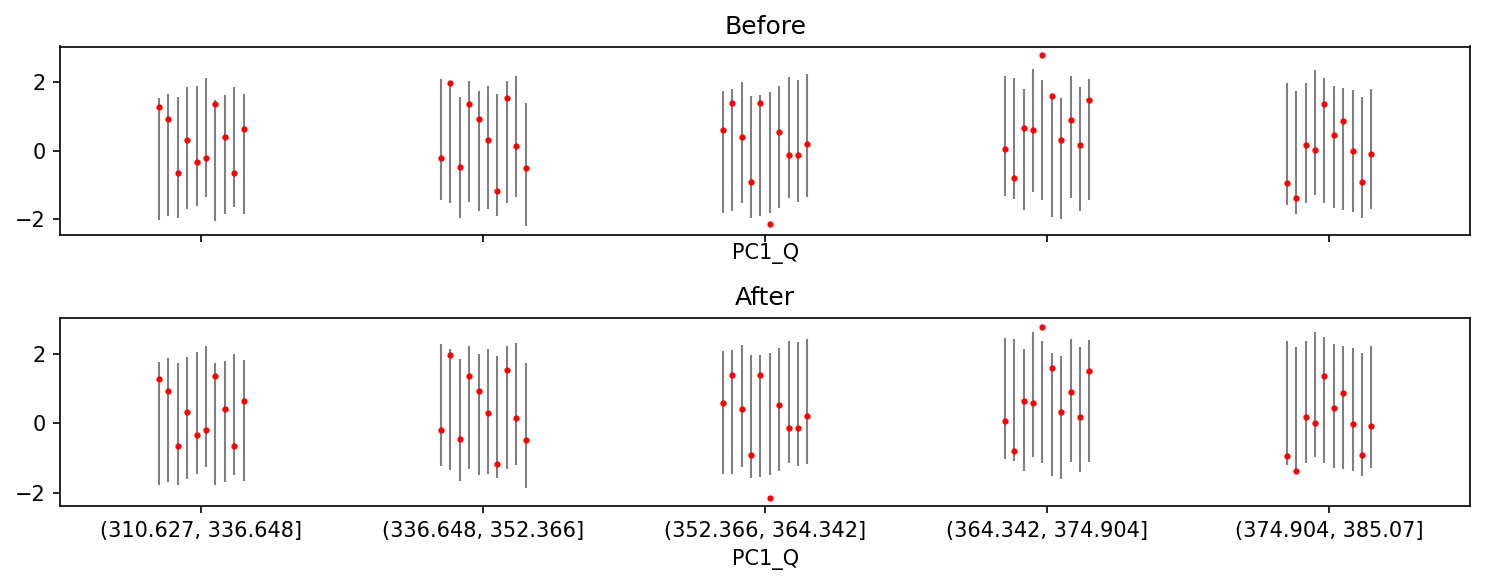

In [31]:
np.random.seed(1)
# use 5% of the individual for calibration
calibrate_idx = np.random.choice(df_admix.index, size=int(len(df_admix) * 0.05), replace=False)

# perform calibration
df1_calibrated = admix_prs.calibrate_pred(
    df_admix,
    true_col="REAL",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    calibrate_idx=calibrate_idx,
    mean_adjust_cols=["PC1"],
)
df1_calibrated[["REAL", "PC1_Q"]] = df_admix[["REAL", "PC1_Q"]].reindex(df1_calibrated.index)

display(
    admix_prs.evaluate(
        df1_calibrated,
        true_col="REAL",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="PC1_Q",
    )
)

# visualize before and after
fig, axes = plt.subplots(figsize=(10, 4), dpi=150, nrows=2, sharex=True)
admix_prs.plot_calibration(
    df=df_admix,
    y_col="REAL",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="PC1_Q",
    ax=axes[0],
)

admix_prs.plot_calibration(
    df=df1_calibrated,
    y_col="REAL",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="PC1_Q",
    ax=axes[1],
)

axes[0].set_title("Before")
axes[1].set_title("After")
fig.tight_layout()

#### Not much difference before and after calibration

## Case 2: variance as a function of covariates

In [27]:
# perform calibration with TARGET_QUANTILE adjusted
df2_calibrated = admix_prs.calibrate_pred(
    df_admix,
    true_col="REAL",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    calibrate_idx=calibrate_idx,
    method="scale",
    quantile_adjust_cols=["PC1"],
    q=TARGET_QUANTILE,
)
df2_calibrated[["REAL", "PC1_Q"]] = df_admix[["REAL", "PC1_Q"]].reindex(
    df2_calibrated.index
)

2022-01-27 17:31.26 [info     ] Regress pred_col=PRED against mean_adjust_cols=[] fitted with `calibrate_index` individuals
2022-01-27 17:31.26 [info     ] mean_model.summary():                             OLS Regression Results                            
Dep. Variable:                   REAL   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.052
Date:                Thu, 27 Jan 2022   Prob (F-statistic):             0.0833
Time:                        17:31:26   Log-Likelihood:                -169.07
No. Observations:                 120   AIC:                             342.1
Df Residuals:                     118   BIC:                             347.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err

/u/home/z/ziqixu09/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,r2,coverage,length
PC1_Q,,,
"(310.627, 336.648]",0.057268,0.906639,3.516780
"(336.648, 352.366]",0.034210,0.906445,3.534279
"(352.366, 364.342]",0.067577,0.904564,3.547832
"(364.342, 374.904]",0.044726,0.906445,3.558684
"(374.904, 385.07]",0.025634,0.912863,3.566564


,r2,coverage,length
PC1_Q,,,
"(310.627, 336.648]",0.057268,0.863071,3.110838
"(336.648, 352.366]",0.034210,0.904366,3.306494
"(352.366, 364.342]",0.067577,0.931535,3.450042
"(364.342, 374.904]",0.044726,0.910603,3.566443
"(374.904, 385.07]",0.025634,0.943983,3.660648


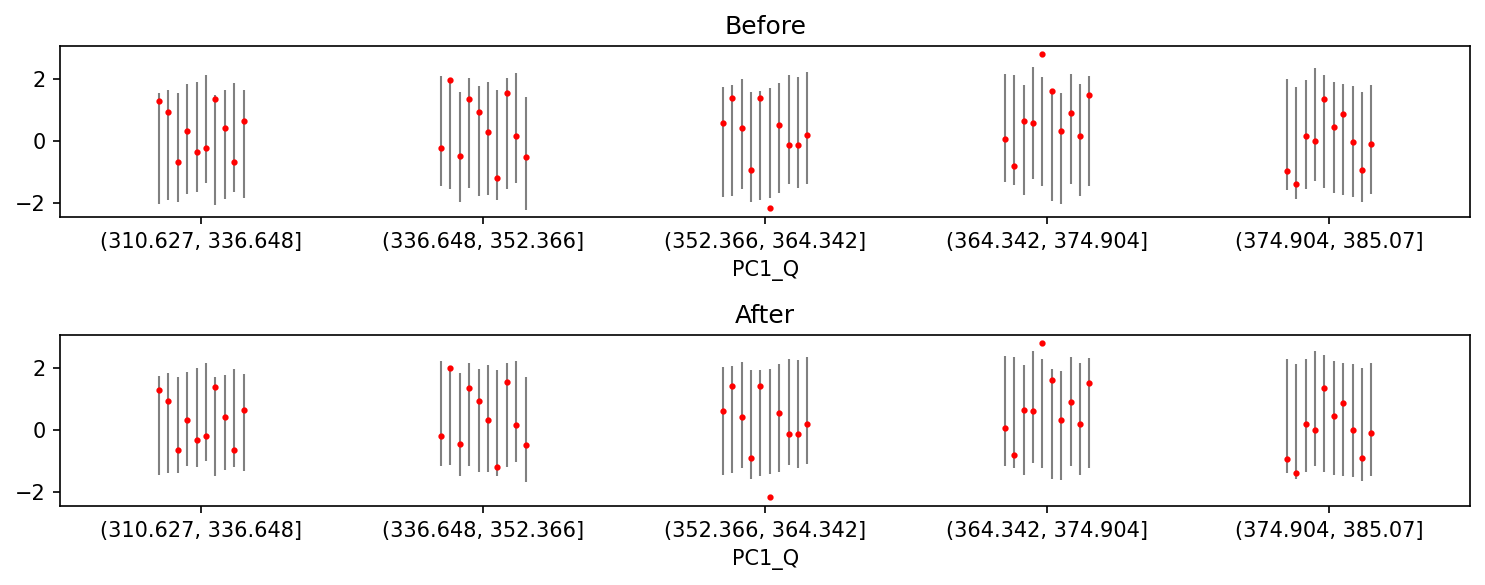

In [30]:
fig, axes = plt.subplots(figsize=(10, 4), dpi=150, nrows=2, sharey=True)
admix_prs.plot_calibration(
    df=df_admix,
    y_col="REAL",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="PC1_Q",
    n=10,
    ax=axes[0],
)
axes[0].set_title("Before")
display(
    admix_prs.evaluate(
        df=df_admix,
        true_col="REAL",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="PC1_Q",
    )
)

admix_prs.plot_calibration(
    df=df2_calibrated,
    y_col="REAL",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="PC1_Q",
    n=10,
    ax=axes[1],
)
axes[1].set_title("After")

display(
    admix_prs.evaluate(
        df=df2_calibrated,
        true_col="REAL",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="PC1_Q",
    )
)

fig.tight_layout()